<a href="https://colab.research.google.com/github/liangli217/PyTorch_ML/blob/main/micrograd_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math

In [ ]:
import math

class Value:

  def __init__(self, data, _children = (), _op= '', label = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self._backward = lambda: None
    self.label = label
    self.grad = 0


  def __repr__(self):
    return f"Value(data={self.data})"


  def __add__(self, other):
    # Ensure 'other' is a Value object for consistent operations
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other): # Handles float + Value
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value((self.data * other.data), (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other): # Handles scalar * Value
    return self * other

  def __sub__(self, other): # Handles Value - other
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data - other.data, (self, other), '-')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad -= 1.0 * out.grad # gradient of -other is -1

    out._backward = _backward
    return out

  def __rsub__(self, other): # Handles other - Value
    # Convert other to a Value and then subtract self
    return Value(other) - self

  def tanh(self):
    n = self.data
    t = ((math.exp(2*n))-1) /(math.exp(2*n) +1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1- t**2) * out.grad

    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d= e +c
d.label= 'd'
d
f= Value(-2.0, label ='f')
L = d*f; L.label ='L'
f

Value(data=-2.0)

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [ ]:
d._op

'+'

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

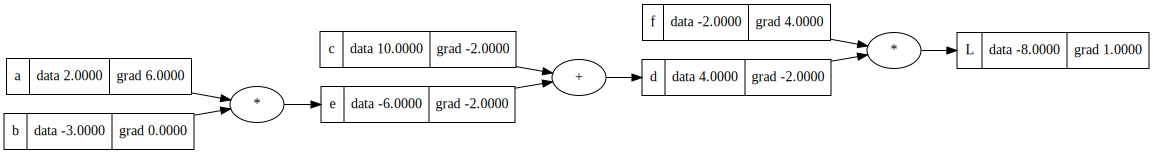

In [ ]:
draw_dot(L)

In [ ]:
L.grad = 1
d.grad = -2
f.grad = 4
c.grad = -2
e.grad = -2
a.grad = 6
b.grad = -4

In [ ]:
def lol():

  h = 0.0001

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d= e +c
  d.label= 'd'
  d
  f= Value(-2.0, label ='f')
  L = d*f; L.label ='L'
  L1=L.data

  a = Value(2.0+h, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d= e +c
  d.label= 'd'
  d
  f= Value(-2.0, label ='f')
  L = d*f; L.label ='L'
  L2=L.data


  print((L2-L1)/h)

lol()






6.000000000021544


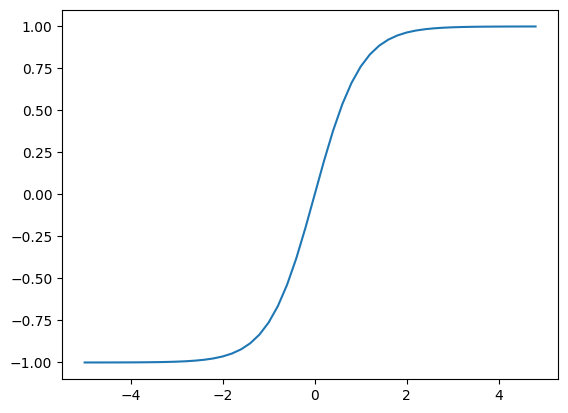

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

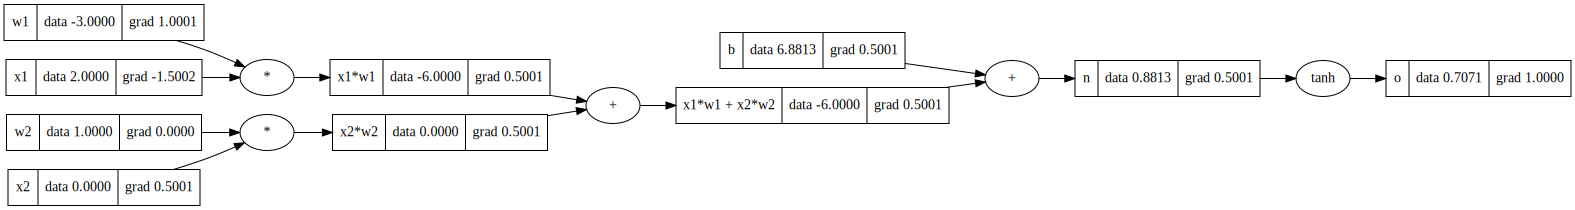

In [ ]:
draw_dot(o)

In [ ]:
o.grad =1

In [ ]:
o.backward()

In [ ]:
n._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
## o = tanh(n)
# do/dn = 1-o**2

In [ ]:
# manually
1-o.data**2
n.grad =0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data* x2w2.grad
x2.grad
x1.grad = w1.data* x1w1.grad

In [ ]:
# Using PyTorch
import torch


In [ ]:
x1 = torch.Tensor([2]).double(); x1.requires_grad = True
x2 = torch.Tensor([0]).double(); x2.requires_grad = True

w1 = torch.Tensor([-3]).double(); w1.requires_grad = True
w2 = torch.Tensor([1]).double(); w2.requires_grad = True


b = torch.Tensor([6.88137358]).double()

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()



print(f"{x2.grad.item()=}")

print(f"{w2.grad.item()=}")

print(f"{x1.grad.item()=}")

print(f"{w1.grad.item()=}")



0.7071066904050358
x2.grad.item()=0.5000001283844369
w2.grad.item()=0.0
x1.grad.item()=-1.5000003851533106
w1.grad.item()=1.0000002567688737


In [ ]:
import random
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []

    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)

    return params


class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.8794213604200983)

In [ ]:
xs = [[2,3,-1], [3, -1,0.5], [0.5, 1, 1], [1,1,-1]]

ys = [1.0, -1, -1, 1]


y_pred = [n(x) for x in xs]

In [ ]:
for k in range(20):
  y_pred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])


  # backward pass
  for p in n.parameters():
    p.grad = 0

  loss.backward()

  for p in n.parameters():
    p.data -= 0.01* p.grad

  print(k, loss.data)



0 0.01035033307909722
1 0.01030691926351926
2 0.01026389612770191
3 0.01022125811980388
4 0.010178999796002503
5 0.010137115817838955
6 0.010095600949642044
7 0.010054450056028154
8 0.010013658099473691
9 0.009973220137958658
10 0.00993313132267831
11 0.00989338689582074
12 0.009853982188408343
13 0.009814912618200722
14 0.009776173687657323
15 0.009737760981957479
16 0.009699670167076409
17 0.009661896987914705
18 0.009624437266480454
19 0.009587286900121195


In [ ]:
y_pred

[Value(data=0.9475673287345286),
 Value(data=-0.9654815993402681),
 Value(data=-0.952701250759622),
 Value(data=0.9416098448342679)]